In [35]:
# !pip install numba==0.56.0

In [28]:
import pandas as pd
import scanpy as sc
import numpy as np

# plotting tools 
import colorcet as cc
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from scDMFK.io import Clustering
# computation
from sklearn.preprocessing import StandardScaler
# from scDMFK.io import get_embedding, draw_umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

In [43]:
def get_embedding(data):
    """ Function to compute the UMAP embedding"""
    data_scaled = StandardScaler().fit_transform(data)

    embedding = umap.UMAP(n_neighbors=10,
                            min_dist=0.5,
                            metric='correlation').fit_transform(data_scaled)
    return embedding


class Clustering():
    def __init__(self, adata, dataname, denoise_method, 
                label, random_seed=None, mode=['raw','denoise'],
                show_plot=False):
        self.adata = adata
        self.dataname = dataname
        self.denoise_method = denoise_method
        self.label = label
        self.mode = mode
        self.random_seed = random_seed
        self.show_plot = show_plot
        self.n_clusters = len(np.unique(self.label))
        if not isinstance(self.random_seed, list):
            self.random_seed = [self.random_seed]
        
        self.datasets = []
        if 'raw' in self.mode:
            self.datasets.append(adata.raw.X) # raw data
        if 'denoise' in self.mode:
            self.datasets.append(adata.X) # denoised data
        if 'latent' in self.mode:
            self.datasets.append(adata.obsm['X_hidden']) # latent repre
        
        result = []
        self.embeddings = []
        self.fignames = []
        for mode, data in zip(self.mode, self.datasets):
            for seed in self.random_seed:
            
                print("seed: %d  Evaluating clustering results for %s data..." % (seed, mode))
                
                ari, nmi, sc, embedding = self.calculate_cluster_results(data, mode, seed)
                result.append([self.dataname, self.denoise_method, mode, seed, ari, nmi, sc])
                figname = '-'.join(str(s).lower() for s in [self.denoise_method, mode, seed]) + '.png'
                self.fignames.append(figname)
                self.embeddings.append(embedding)
                
        self.output = np.array(result)
        self.output = pd.DataFrame(self.output, 
                            columns=["data", "denoise method", "mode", "random seed", "ARI", "NMI", "SC"])
    
    def get_output(self):
        return self.output
    
    def get_umap(self,method=None, mode=None, seed=None, same_figure=False, output_dir=None):
        search = lambda string, key: True if string is None else any([str(s) in key for s in string])
        inds = [
            (search(method, name) and search(mode, name) and search(seed, name)) for name in self.fignames]
        from itertools import compress
        
        embeddings = list(compress(self.embeddings, inds))
        fignames = list(compress(self.fignames,inds))
        
        if same_figure:
            self.draw_multiple_umap(embeddings, fignames, output_dir)
        else:
            for figname, emb in zip(fignames, embeddings):
                self.draw_umap(emb, figname, output_dir)
            
            
    def calculate_cluster_results(self, data, name, seed):
        if not isinstance(data, np.ndarray):
            data = np.array(data)
        
        if seed is not None:
            np.random.seed(seed) #set random seet for reproduceable results

        # get UMAP 2-D embedding
        embedding = get_embedding(data)
        # K-means for clustering umi embedings
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=10).fit(embedding)
        labels = kmeans.labels_

        # Calculate metrics
        ari = adjusted_rand_score(self.label, labels)
        nmi = normalized_mutual_info_score(self.label, labels)
        sc = silhouette_score(embedding, labels)
        print(f'Adjusted Rand Index: {ari}')
        print(f'Normalized Mutual Information: {nmi}')
        print(f'Silhouette Coefficient: {sc}')
        
        return ari, nmi, sc, embedding

    def draw_umap(self, embedding, figname, output_dir=None, figsize=(15, 10), labelsize=12):  
        label = self.label

        palette = sns.color_palette(cc.glasbey, n_colors=len(np.unique(label)))
        fig, ax = plt.subplots(figsize=figsize)

        plt.xlim([np.min(embedding[:, 0]) - 0.5, np.max(embedding[:, 0]) + 1.5])
        plt.ylim([np.min(embedding[:, 1]) - 0.5, np.max(embedding[:, 1]) + 0.5])
        plt.xlabel('UMAP 1', fontsize=labelsize)
        plt.ylabel('UMAP 2', fontsize=labelsize)
        plt.title(figname[:-4])

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=label, 
                    hue_order=list(np.unique(label)), palette=palette)
        leg = plt.legend(prop={'size': labelsize}, loc='upper right', markerscale=2.00)
        leg.get_frame().set_alpha(0.9)
        plt.setp(ax, xticks=[], yticks=[])
        plt.show()
        if output_dir is not None:
            import os
            fig.savefig(os.path.join(output_dir, figname))
    
    def draw_multiple_umap(self, embedding, names=None, output_dir=None, labelsize=14):
        label = self.label
    
        if not isinstance(embedding, list):
            embedding = [embedding]
        names = [names for i in range(len(embedding))] if names is None else [s[:-4] for s in names]
        
        palette = sns.color_palette(cc.glasbey, n_colors=len(np.unique(label)))
        fig, ax = plt.subplots(1, len(embedding), figsize=(len(embedding)*12.5, 10))

        for (i, embed), figname in zip(enumerate(embedding), names):
            ax[i].set_xlim([np.min(embed[:, 0]) - 0.5, np.max(embed[:, 0]) + 1.5])
            ax[i].set_ylim([np.min(embed[:, 1]) - 0.5, np.max(embed[:, 1]) + 0.5])
            ax[i].set_xlabel('UMAP 1', fontsize=labelsize)
            ax[i].set_ylabel('UMAP 2', fontsize=labelsize)
            ax[i].set_title(figname)
            ax[i].spines['right'].set_visible(False)
            ax[i].spines['top'].set_visible(False)
            
            sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=label, 
                        hue_order=list(np.unique(label)), palette=palette, ax=ax[i])
            leg = ax[i].legend(prop={'size': labelsize}, loc='upper right', markerscale=2.00)
            leg.get_frame().set_alpha(0.9)
            plt.setp(ax[i], xticks=[], yticks=[])
        
        plt.show()
        if output_dir is not None:
            import os
            fig.savefig(os.path.join(output_dir, self.denoise_method+'-results.png'))

In [53]:
arr = np.array([[1,1,1,1]])
arr = np.append(arr, [[2,2,2,2]], axis=0)
# pd.DataFrame(arr)

,0,1,2,3
0,1,1,1,1
1,2,2,2,2


## 1. Endoderm Cells

In [41]:
dataset = 'endoderm'
label = pd.read_csv('data/'+dataset+'/cell_label.csv').label # true labels

num_genes = [500,1000,5000,10000]
data_folders = [dataset] + [dataset + '-%s'%n_genes for n_genes in num_genes]
denoise_methods = ['multinomial', 'zinb', 'weight mse','mask mse']
mode = ['raw', 'denoise']
random_seed = [1111,2222,3333,4444,5555,6666,7777,8888,9999,10000]

for dn_method in [denoise_methods[0]]:
    for data in [data_folders[0]]:
        df_dn = sc.read('results/' + data + '/results-%s.h5ad' %dn_method )
        df_cluster = Clustering(adata=df_dn, dataname=data,
                        denoise_method=dn_method, 
                        label=label, random_seed=random_seed[0], mode=mode)

        df_cluster.get_output()
        

seed: 1111  Evaluating clustering results for raw data...
Adjusted Rand Index: 0.5761339107274353
Normalized Mutual Information: 0.7305516790817747
Silhouette Coefficient: 0.5607007145881653
seed: 1111  Evaluating clustering results for denoise data...
Adjusted Rand Index: 0.756436398934021
Normalized Mutual Information: 0.8539087193952678
Silhouette Coefficient: 0.61918705701828


In [42]:
df_cluster.get_output()

,denoise method,dataname,random seed,ARI,NMI,SC
0,multinomial,raw,1111,0.5761339107274353,0.7305516790817747,0.5607007
1,multinomial,denoise,1111,0.756436398934021,0.8539087193952678,0.61918706


In [18]:
# data_files = ['endoderm','Quake_10x_Bladder','Quake_10x_Limb_Muscle','Quake_10x_Spleen','Young']

datasets = 'endoderm'
end_multinom = sc.read('results/' + data + '/results-multinomial.h5ad')
end_zinb = sc.read('results/' + data + '/results-zinb.h5ad')
end_wmse = sc.read('results/' + data + '/results-weight mse.h5ad')
end_mmse = sc.read('results/' + data + '/results-mask mse.h5ad')

In [31]:
denoise_method = 'multinomial'
mode = ['raw', 'denoise', 'latent']
random_seed = [1111,2222,3333,4444,5555,6666,7777,8888,9999,10000]

# true labels
end_label = [label.split("_")[0] for label in end_multinom.obs_names.to_list()]

multinom = Clustering(adata=end_multinom, denoise_method=denoise_method, 
                    label=end_label, random_seed=1111, mode=['raw','denoise'])

multinom.get_output()

seed: 1111  Evaluating clustering results for raw data...
Adjusted Rand Index: 0.6109946717506702
Normalized Mutual Information: 0.7567714218454306
Silhouette Coefficient: 0.5604827404022217
seed: 1111  Evaluating clustering results for denoise data...
Adjusted Rand Index: 0.7366601770043341
Normalized Mutual Information: 0.8554696177688418
Silhouette Coefficient: 0.6678236722946167


,denoise method,dataname,random seed,ARI,NMI,SC
0,multinomial,raw,1111,0.6109946717506702,0.7567714218454306,0.56048274
1,multinomial,denoise,1111,0.7366601770043341,0.8554696177688418,0.6678237


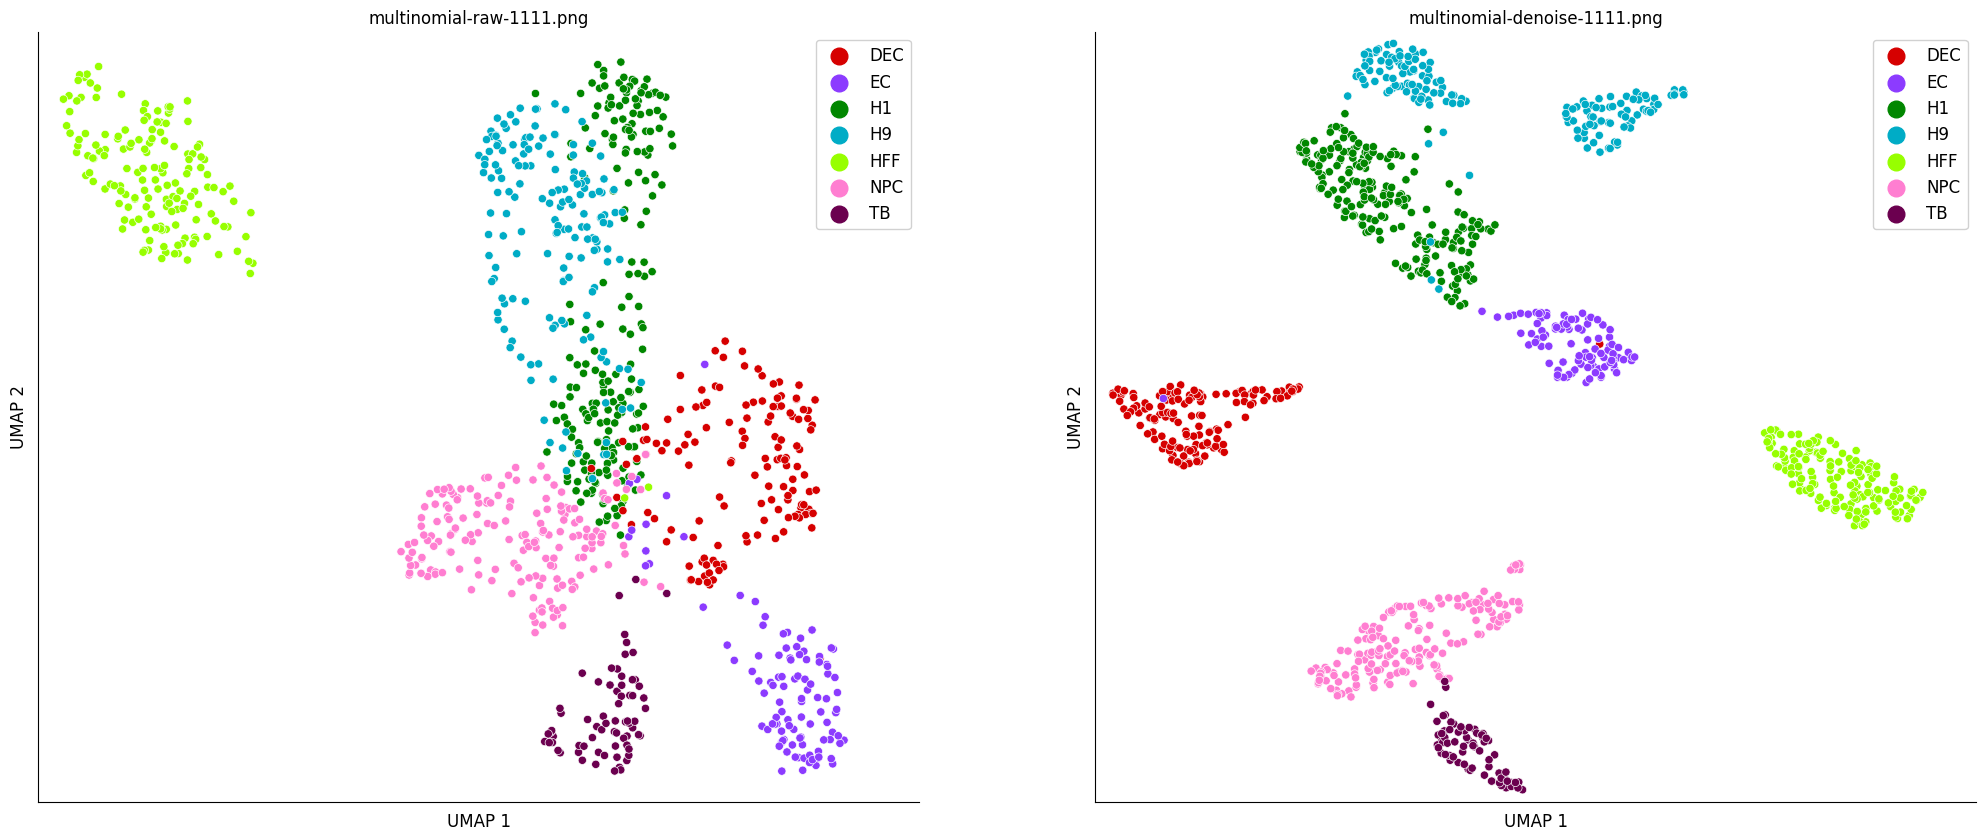

In [32]:
multinom_results = multinom.get_output()
multinom_results
multinom.get_umap(same_figure=True, output_dir='results/endoderm')

In [104]:
def draw_multiple_umap(embedding, label, ax=None, figsize=(15, 10), labelsize=12):
    plt.close()
    palette = sns.color_palette(cc.glasbey, n_colors=len(np.unique(label)))
    if isinstance(embedding, list):
        fig, ax = plt.subplots(1, len(embedding), figsize=(len(embedding)*12.5, 10))

    for i, embed in enumerate(embedding):
        ax[i].set_xlim([np.min(embed[:, 0]) - 0.5, np.max(embed[:, 0]) + 1.5])
        ax[i].set_ylim([np.min(embed[:, 1]) - 0.5, np.max(embed[:, 1]) + 0.5])
        ax[i].set_xlabel('UMAP 1', fontsize=labelsize)
        ax[i].set_ylabel('UMAP 2', fontsize=labelsize)

        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        
        sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=label, 
                    hue_order=list(np.unique(label)), palette=palette, ax=ax[i])
        leg = ax[i].legend(prop={'size': labelsize}, loc='upper right', markerscale=2.00)
        leg.get_frame().set_alpha(0.9)
        plt.setp(ax[i], xticks=[], yticks=[])
    plt.show()

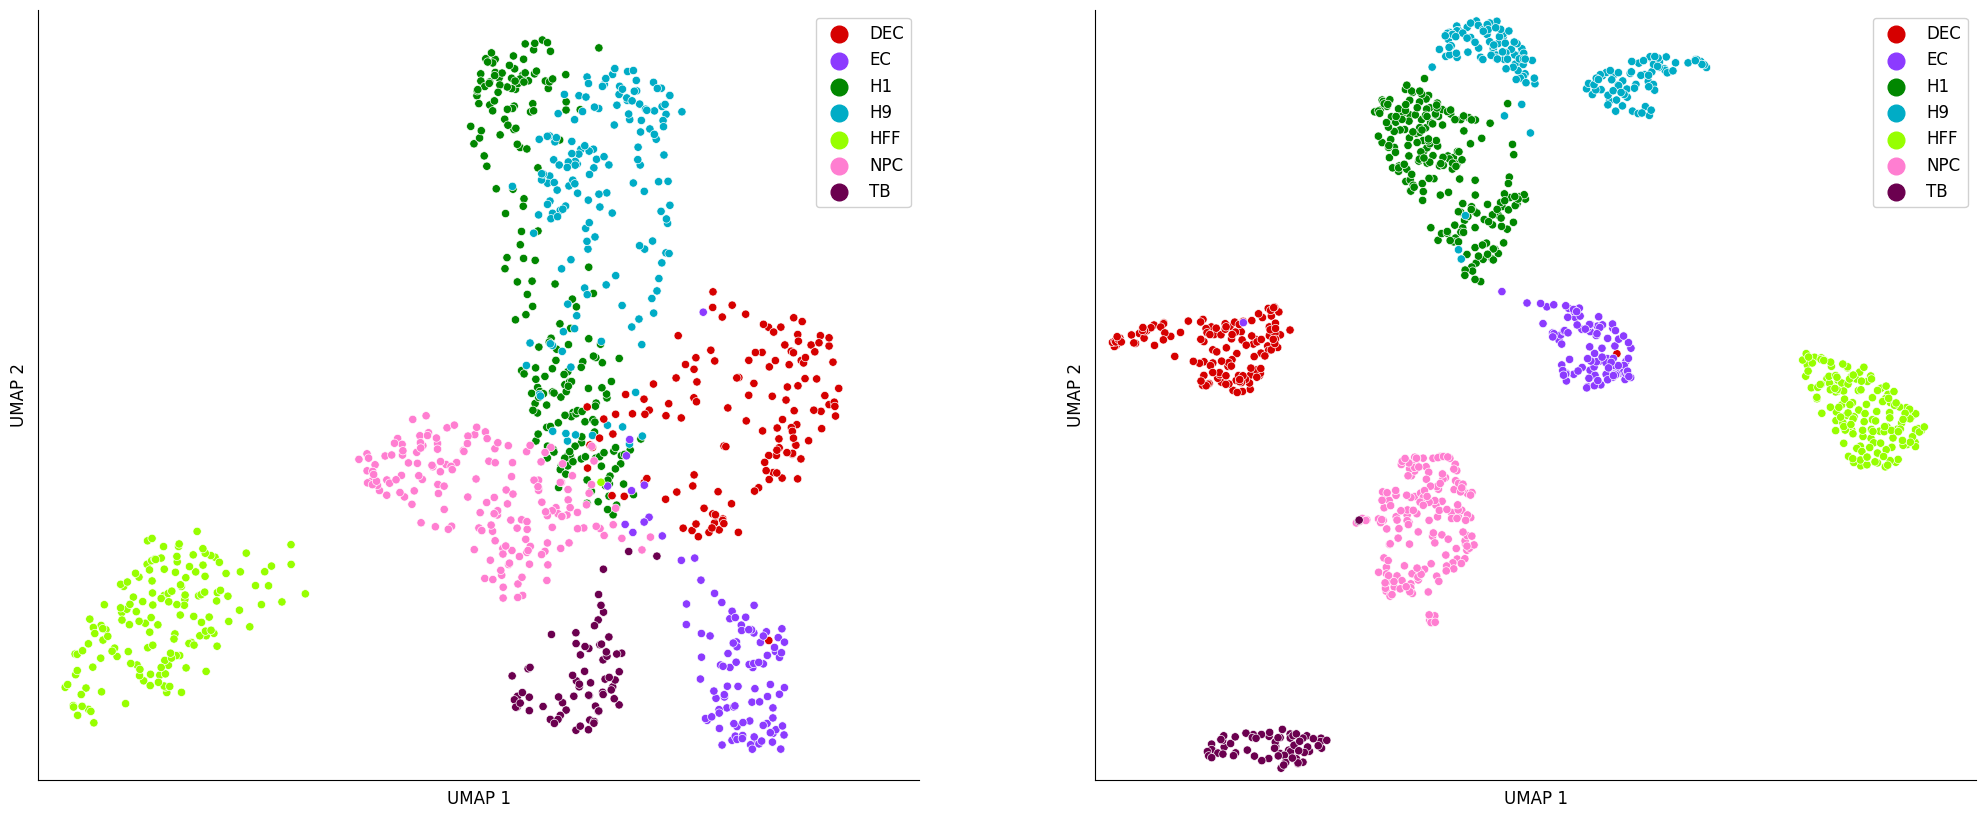

In [106]:
np.random.seed(1111) #set random seet for reproduceable results

# get UMAP 2-D embedding
multinom_raw_embed = get_embedding(end_multinom.raw.X)
multinom_dn_embed = get_embedding(end_multinom.X)
draw_multiple_umap([multinom_raw_embed,multinom_dn_embed], end_label, ax=ax)


In [ ]:
denoise_method = 'zinb'
mode = ['raw', 'denoise', 'latent']
random_seed = [1111,2222,3333,4444,5555,6666,7777,8888,9999,10000]

zinb = Clustering(adata=end_zinb, denoise_method=denoise_method, 
                    label=end_label, random_seed=random_seed[:5], mode=mode)

zinv_output = zinb.get_output()